## Building a Large Language Model (From Scratch) Chapter 4: Implementing a GPT Model from Scratch to Generate Text

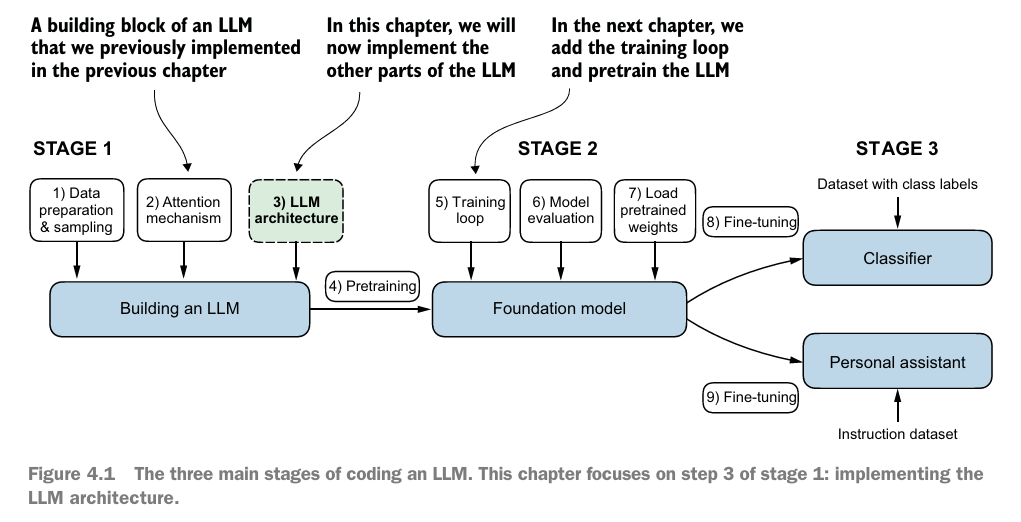

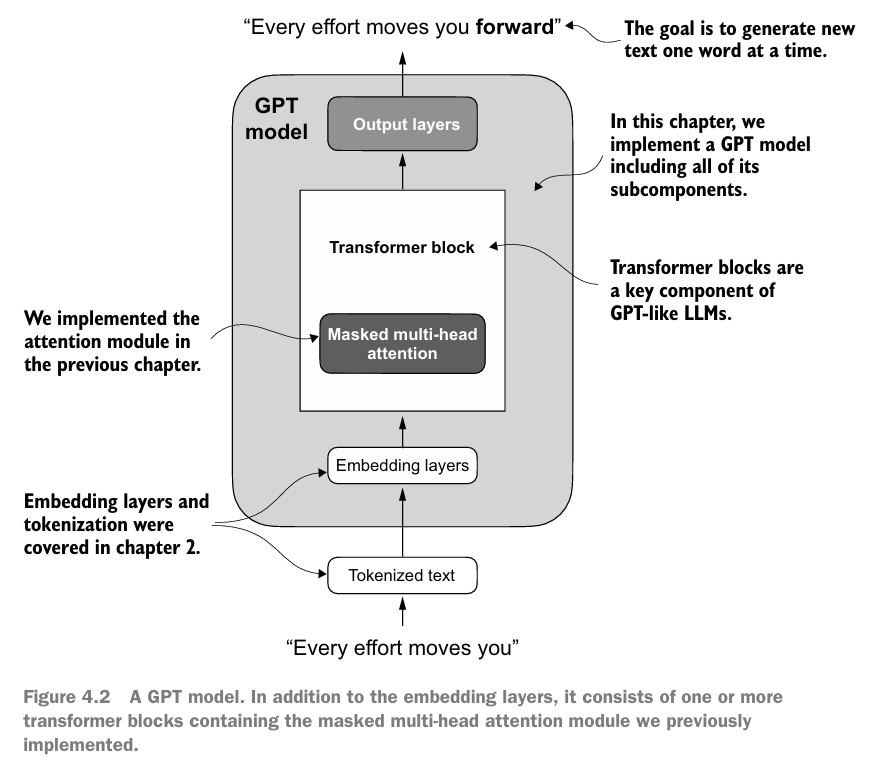

In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257,     # Vocabulary size
"context_length": 1024,  # Context length
"emb_dim": 768,          # Embedding dimension
"n_heads": 12,           # Number of attention heads
"n_layers": 12,          # Number of layers
"drop_rate": 0.1,        # Dropout rate
"qkv_bias": False        # Query-Key-Value bias
}

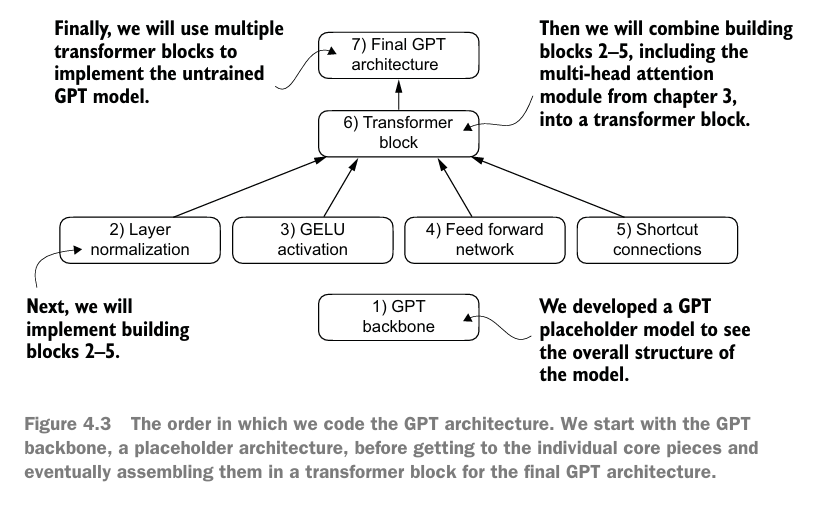

Primero creamos un dummy gpt model y después lo hacemos bien

In [2]:
import torch
import torch.nn as nn

In [ ]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(              
        *[DummyTransformerBlock(cfg)              
            for _ in range(cfg["n_layers"])]        
        )                                             
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])    
        self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):   #placeholder
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x):    
        return x

class DummyLayerNorm(nn.Module):          
    def __init__(self, normalized_shape, eps=1e-5):   #placeholder
        super().__init__()
    def forward(self, x):
        return x

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


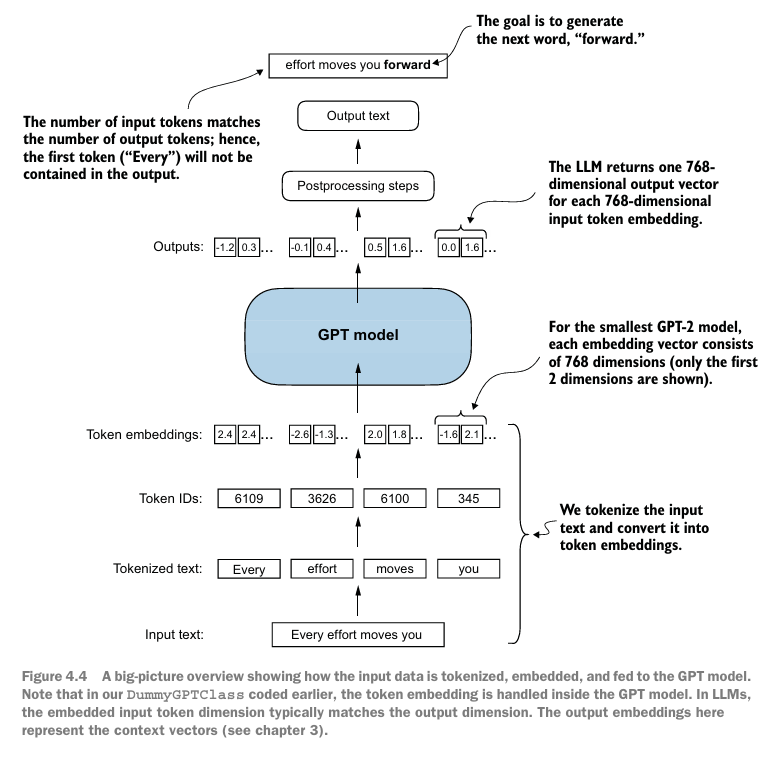

Probemos el dummy model con el batch de dos textos creado recién

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


La dimensión es 2 (dos textos) x 4 (cantidad de tokens en cada texto) x 50527 (tamaño del vocabulario). Después, cuando implementemos el postprocesamiento, vamos a transformar estos vectores en token IDs y luego en palabras.

Ahora que vimos una forma top-down de como funciona el dummy gpt model, vamos a codear los dos placeholders (ver código arriba). 
1) LayerNorm y 
2) TransformerBlock

## LayerNorm

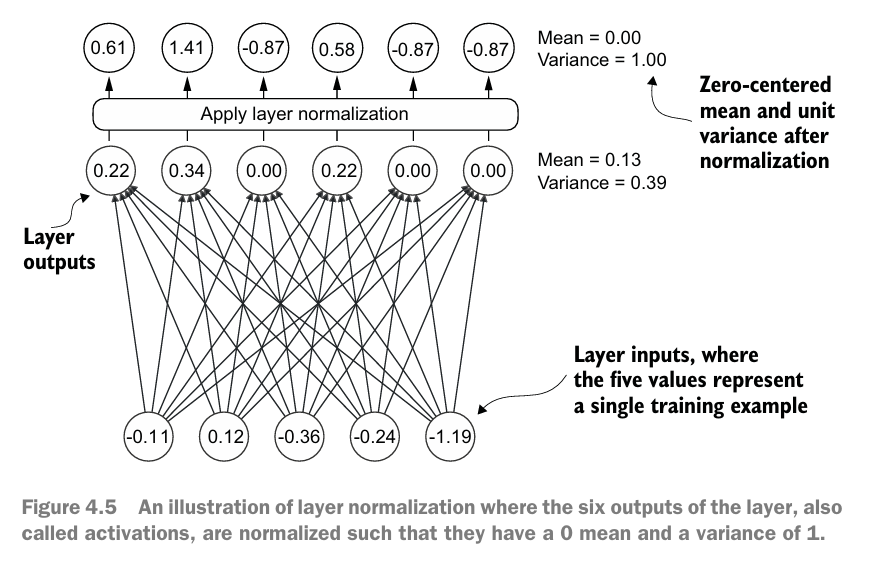

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)    
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [11]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-9.9341e-09],
        [-5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Entonces tenemos el PyTorch module

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [14]:
#hagamos un ejemplo

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GELU

Vamos a implementar la GELU para la parte feed forward

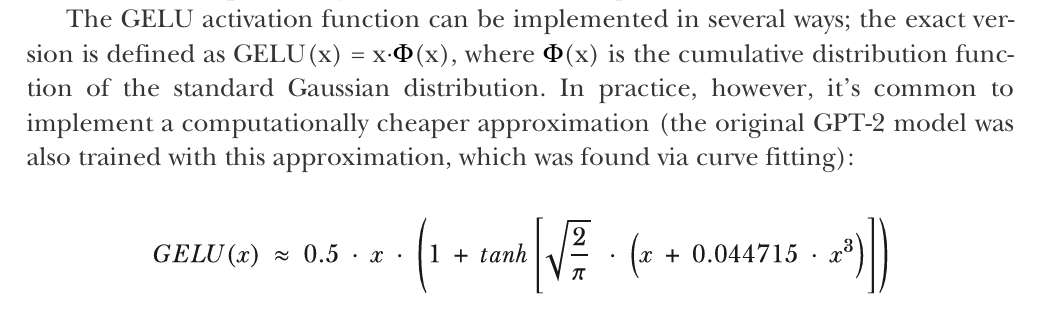

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
%pip install matplotlib

  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 9.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.2 MB/s eta 0:00:00
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------------- - 2.1/2.2 MB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 9.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


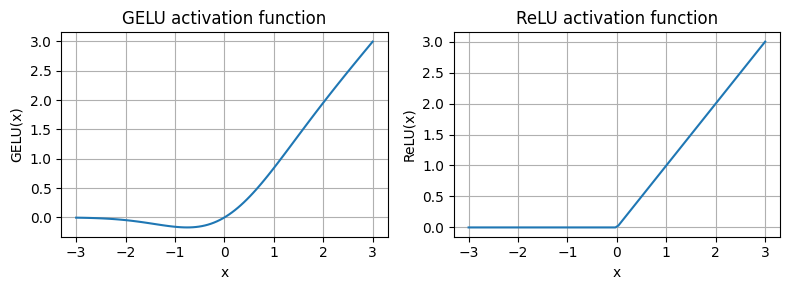

In [18]:
#graficamos la GELU contra RELU

import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)    
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

Usemos la GELU para implementar el modulo FeedForward

### FeedForward

In [19]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )
    def forward(self, x):
        return self.layers(x)

Esto es lo que acabamos de hacer

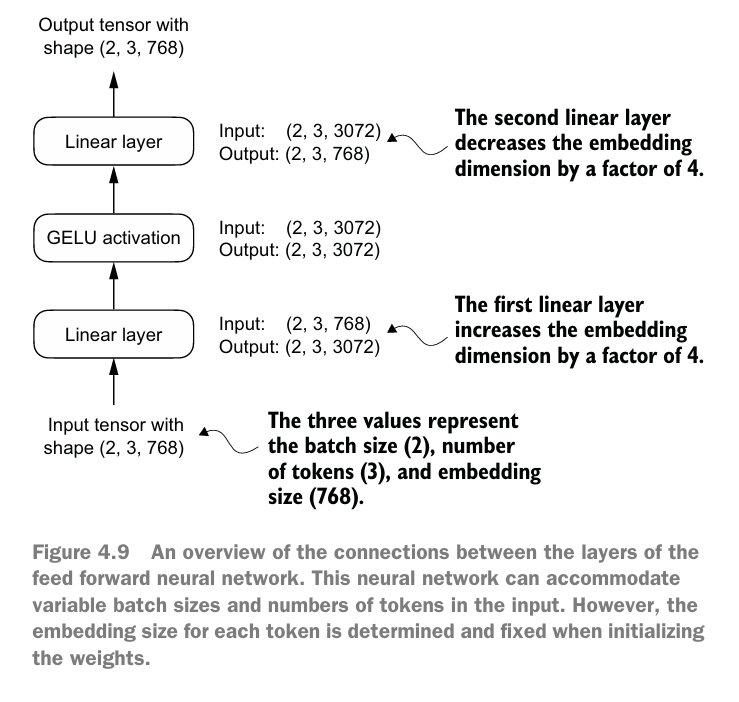

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)         
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


### Skip Connections (o Shortcut o Residual)

Sirven para mejorar el flow del gradiente en la backward pass y mitigar el efecto de los vanishing o exploding gradients. Esto se logra agregando el output de una layer al de otra layer mas adelante.

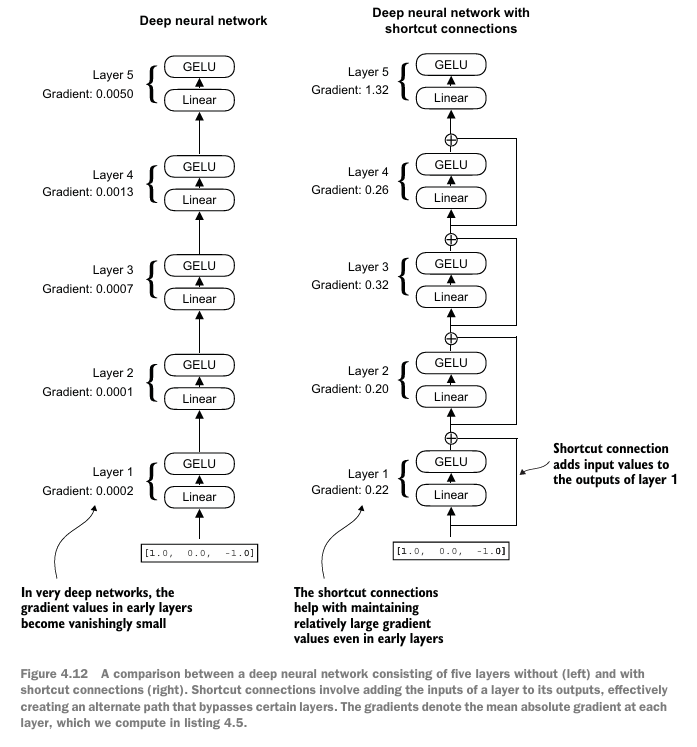

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
    nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                  GELU()),
    nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                  GELU()),
    nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                  GELU()),
    nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                  GELU()),
    nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                  GELU())
 ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)        
            if self.use_shortcut and x.shape == layer_output.shape:   
                x = x + layer_output
            else:
                x = layer_output
        return x

In [22]:
#ejemplo sin el shortcut

layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)                           
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

Después hacemos una función que compute los gradientes en la backward pass del modelo

In [25]:
def print_gradients(model, x):
    output = model(x)            
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)   
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

Veamos los gradientes en el modelo sin shortcut connections

In [27]:
print_gradients(model_without_shortcut, sample_input) # vanishing gradients

layers.0.0.weight has gradient mean of 0.00040347175672650337
layers.1.0.weight has gradient mean of 0.0002402232203166932
layers.2.0.weight has gradient mean of 0.0014304083306342363
layers.3.0.weight has gradient mean of 0.002797747729346156
layers.4.0.weight has gradient mean of 0.010099292732775211


Comparemos con el modelo que tiene skip connections

In [28]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


## Transformer Block

Vamos a juntar las attention y linear layers para hacer el transformer block

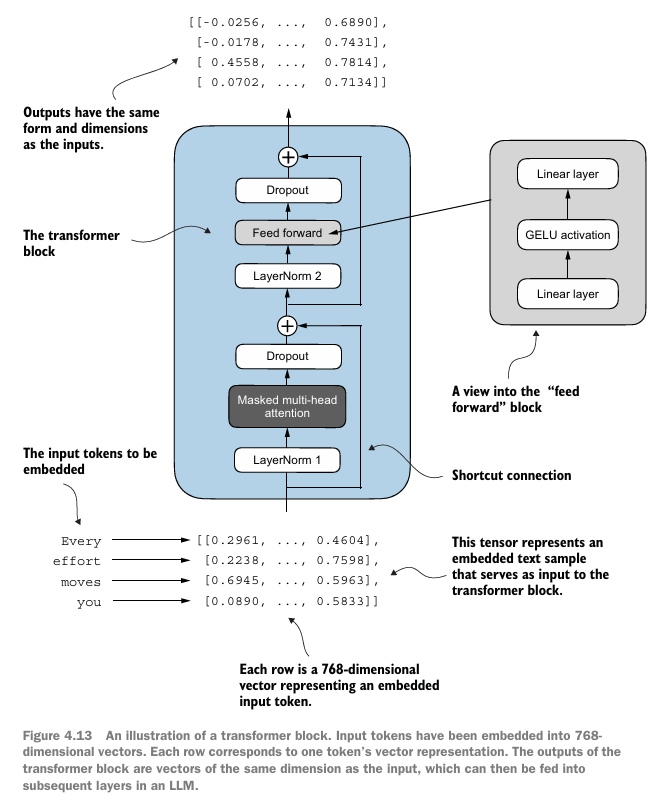

In [ ]:
%pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [32]:
import import_ipynb

In [33]:
from ch3 import MultiHeadAttention

In [35]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"], 
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut     
        shortcut = x        
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

Hagamos un ejemplo

In [36]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                  
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Ahora vamos a juntar todo para la última parte

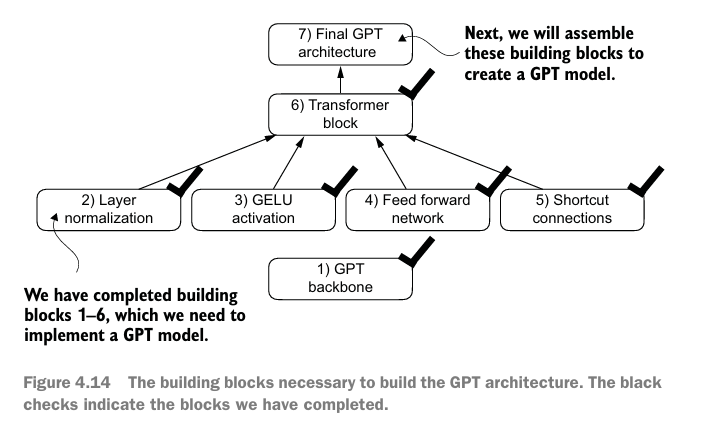

## GPT Architecture

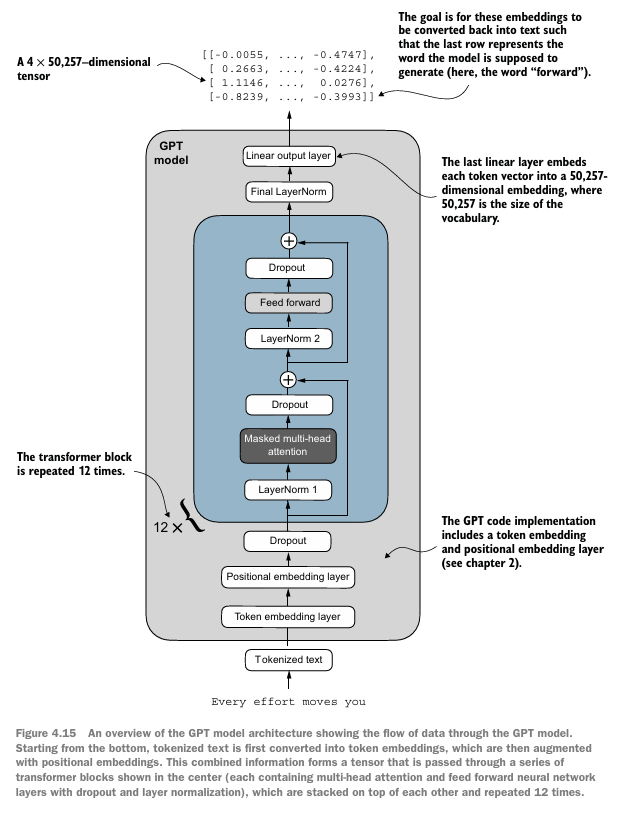

In [39]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [40]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


Después vamos a ver como pasar de estos output vectors de dimensión 50257 a tokens

Veamos la cantidad de parámetros que tiene el modelo usando numel()

In [41]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Tenemos 163M de parámetros en vez de 124M porque no usamos "Weight Tying", que reusa los parámetros de la token embedding layer en la output layer. Esto es usado en el modelo de GPT-2 original, por eso este tiene 124M.

In [42]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [44]:
# si sacamos la output layer count:

total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
    f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


Ahora veamos los memory requirements del modelo con 163M de parámetros

In [45]:
total_size_bytes = total_params * 4      
total_size_mb = total_size_bytes / (1024 * 1024)    
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generando texto

Vamos a implementar el código que devuelve texto a partir de los output embeddings del modelo

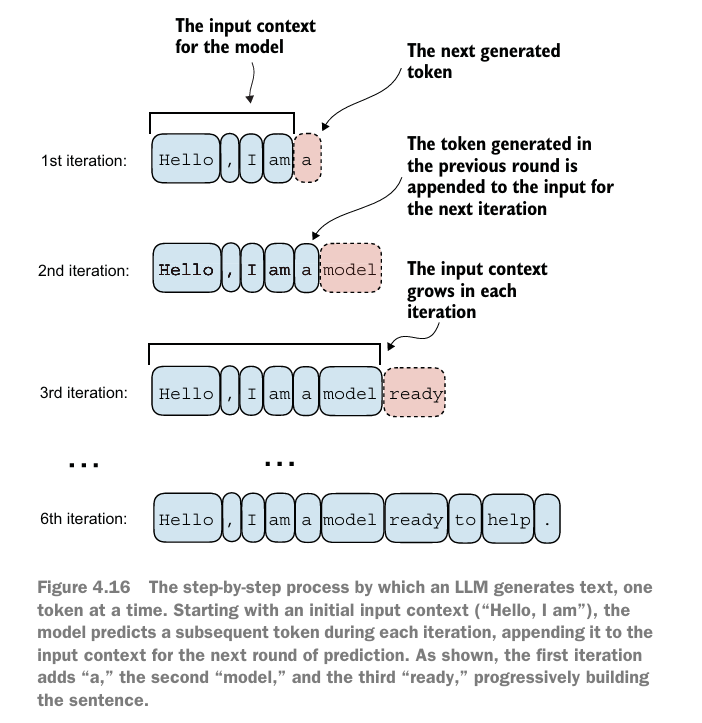

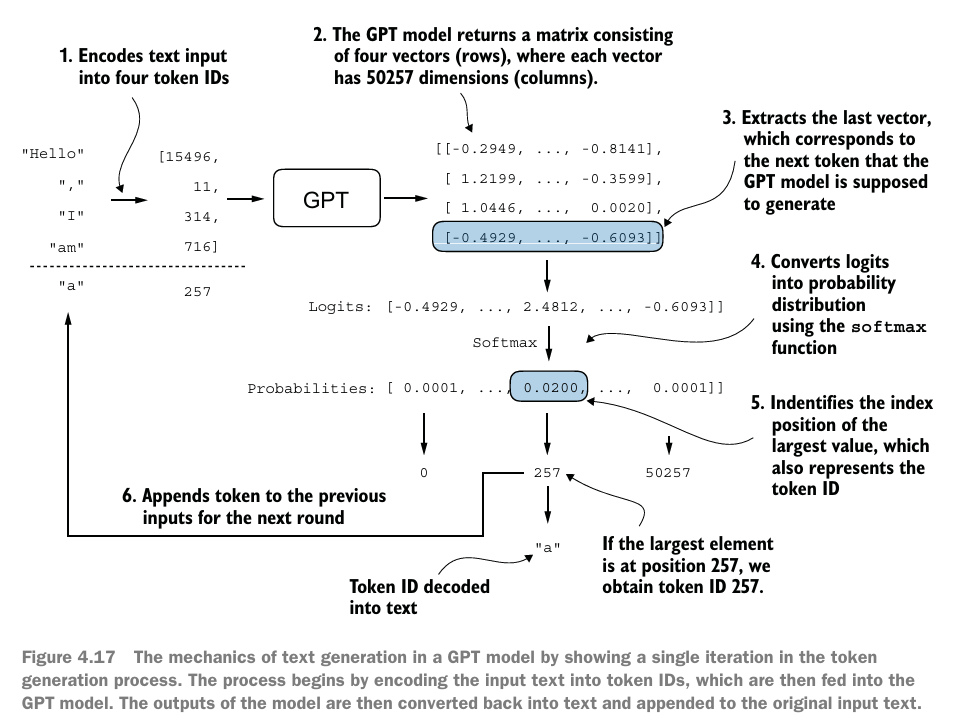

In [47]:
# ver como funciona cada parte del código y dimensiones de cada cosa (pag. 124 libro)

def generate_text_simple(model, idx,                
                max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]   
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]                   
        probas = torch.softmax(logits, dim=-1)          
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   
        idx = torch.cat((idx, idx_next), dim=1)    
    return idx

Veamos un ejemplo

In [48]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)   
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [49]:
model.eval() #Disables dropout and random stuff since we are not training the model          
out = generate_text_simple(
model=model,
idx=encoded_tensor, 
max_new_tokens=6, 
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


Decodifiquemos el output

In [50]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Devuelve basura porque todavía no entrenamos el modelo